### Importamos mediapipe y las librerias que vamos a utilizar.

En este proyecto utilizaremos Mediapipe, una poderosa biblioteca desarrollada por Google para facilitar la implementación de soluciones complejas de visión por computadora. Junto a Mediapipe, importaremos otras bibliotecas esenciales como NumPy para el manejo de datos numéricos, OpenCV para procesar imágenes, y Matplotlib para la visualización de resultados. 

In [10]:
import cv2
import mediapipe as mp
import urllib.request
import numpy as np
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation
import PyQt5
from PIL import Image
from IPython.display import Video

In [11]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic = mp.solutions.holistic
mp_pose = mp.solutions.pose
mp_face_mesh = mp.solutions.face_mesh

### Obtenemos la imagen desde internet

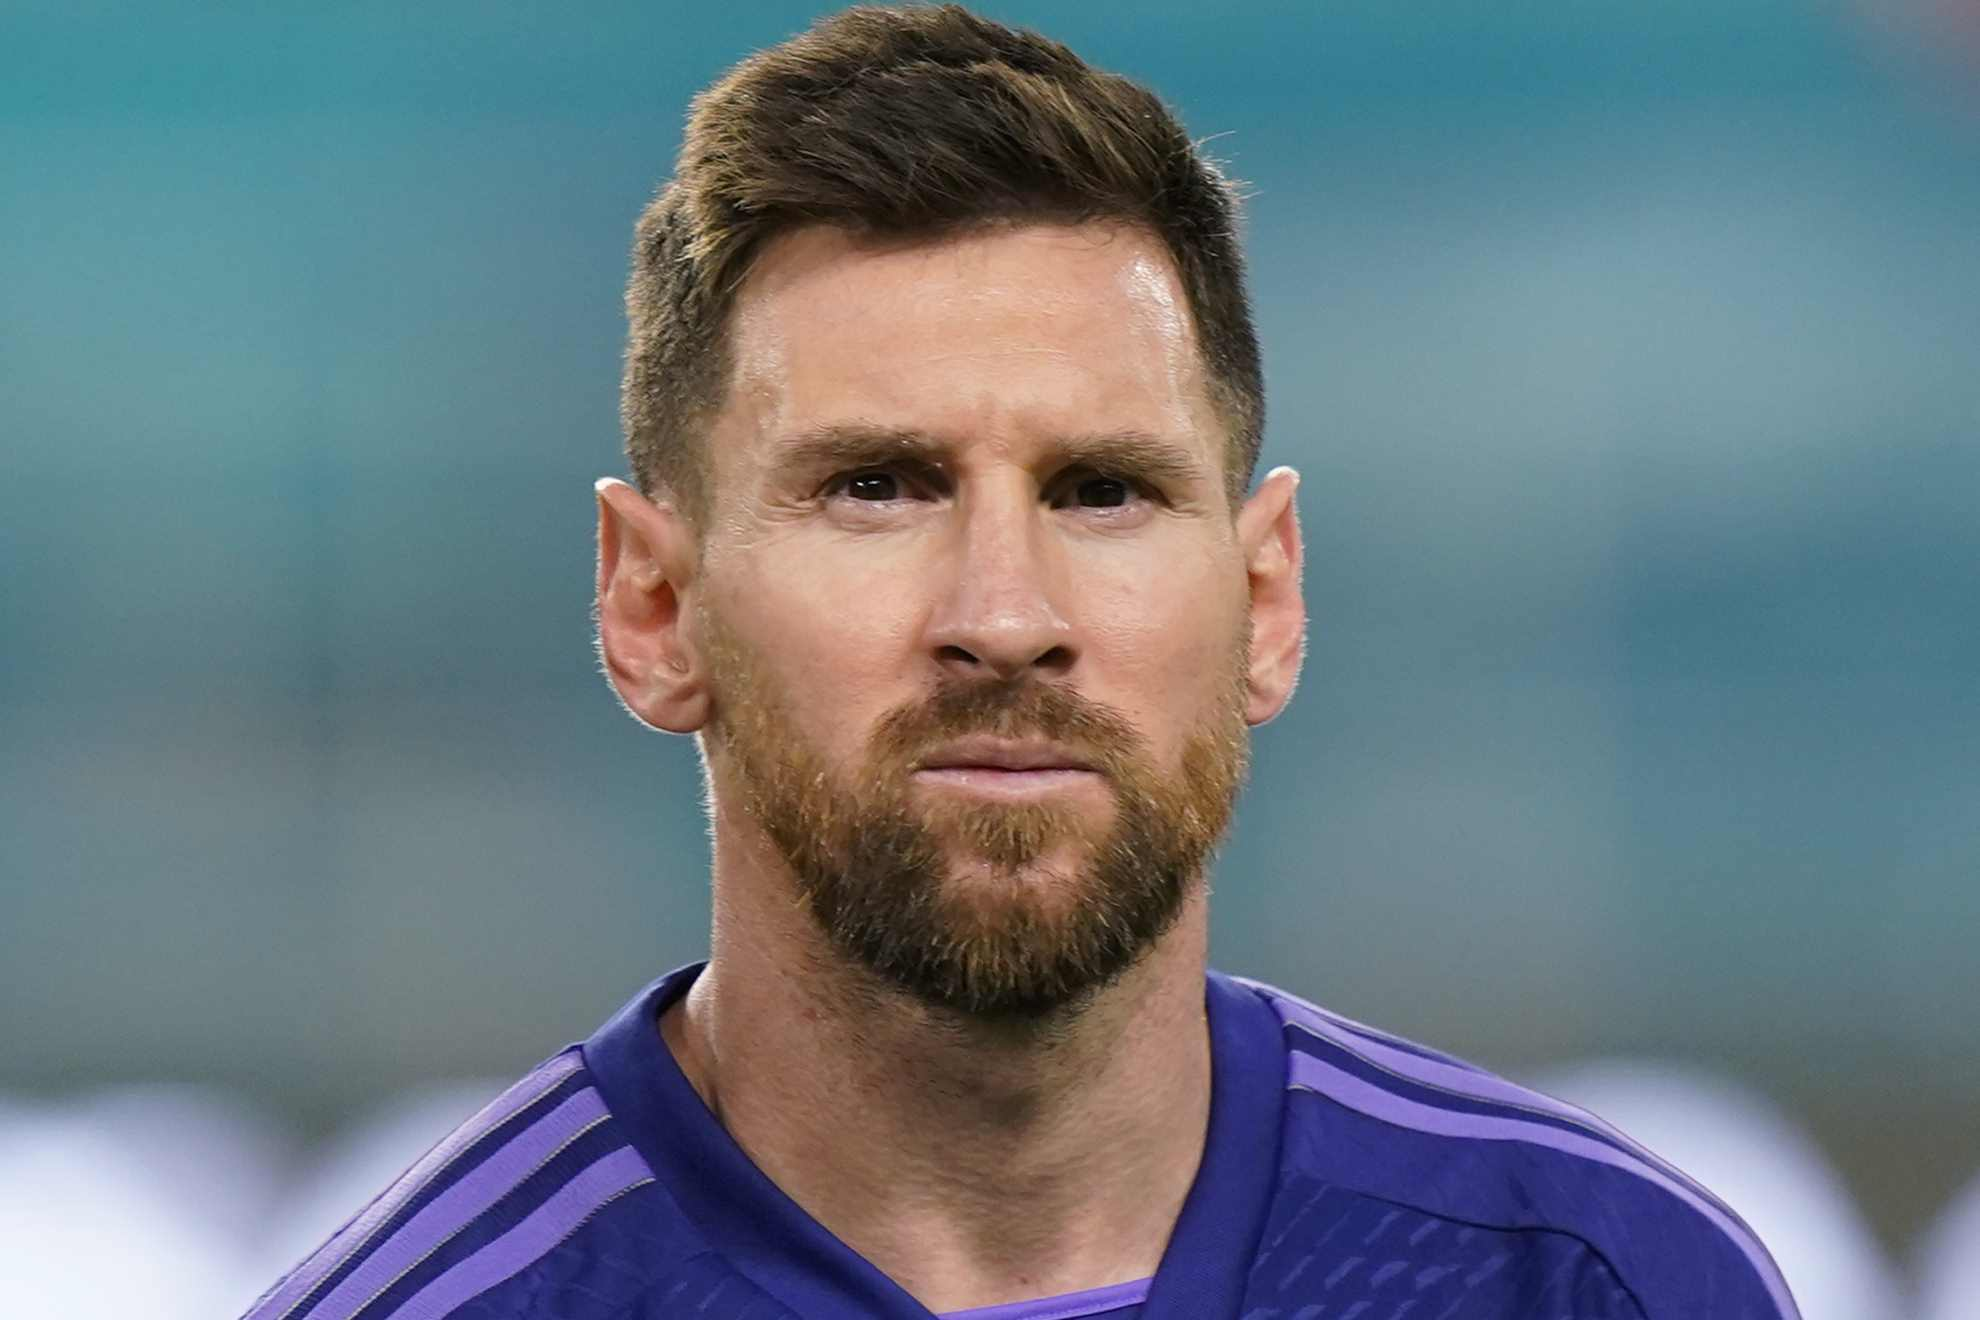

In [12]:
face_url = "https://e00-mx-marca.uecdn.es/mx/assets/multimedia/imagenes/2023/07/12/16891804902395.jpg"
urllib.request.urlretrieve(face_url, "face_image.jpg")

img = Image.open('face_image.jpg')
display(img)

In [13]:
import cv2
import mediapipe as mp

# Define the path to the image file
file = 'face_image.jpg'

# Setup drawing specifications for visualization (optional)
drawing_spec = mp.solutions.drawing_utils.DrawingSpec(thickness=2, circle_radius=1, color=(4, 244, 4))

# Create a face mesh object with specified configurations
with mp.solutions.face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5) as face_mesh:

    # Read image file using OpenCV
    image = cv2.imread(file)
    
    # Check if image is loaded
    if image is None:
        print(f"Error: Image at '{file}' could not be loaded.")
    else:
        # Convert the image from BGR to RGB, process it, and check for faces
        results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        
        # Check if any faces are found
        face_found = bool(results.multi_face_landmarks)
        
        if face_found:
            print("Face detected in the image.")
            
        else:
            print("No face detected in the image.")


Face detected in the image.


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


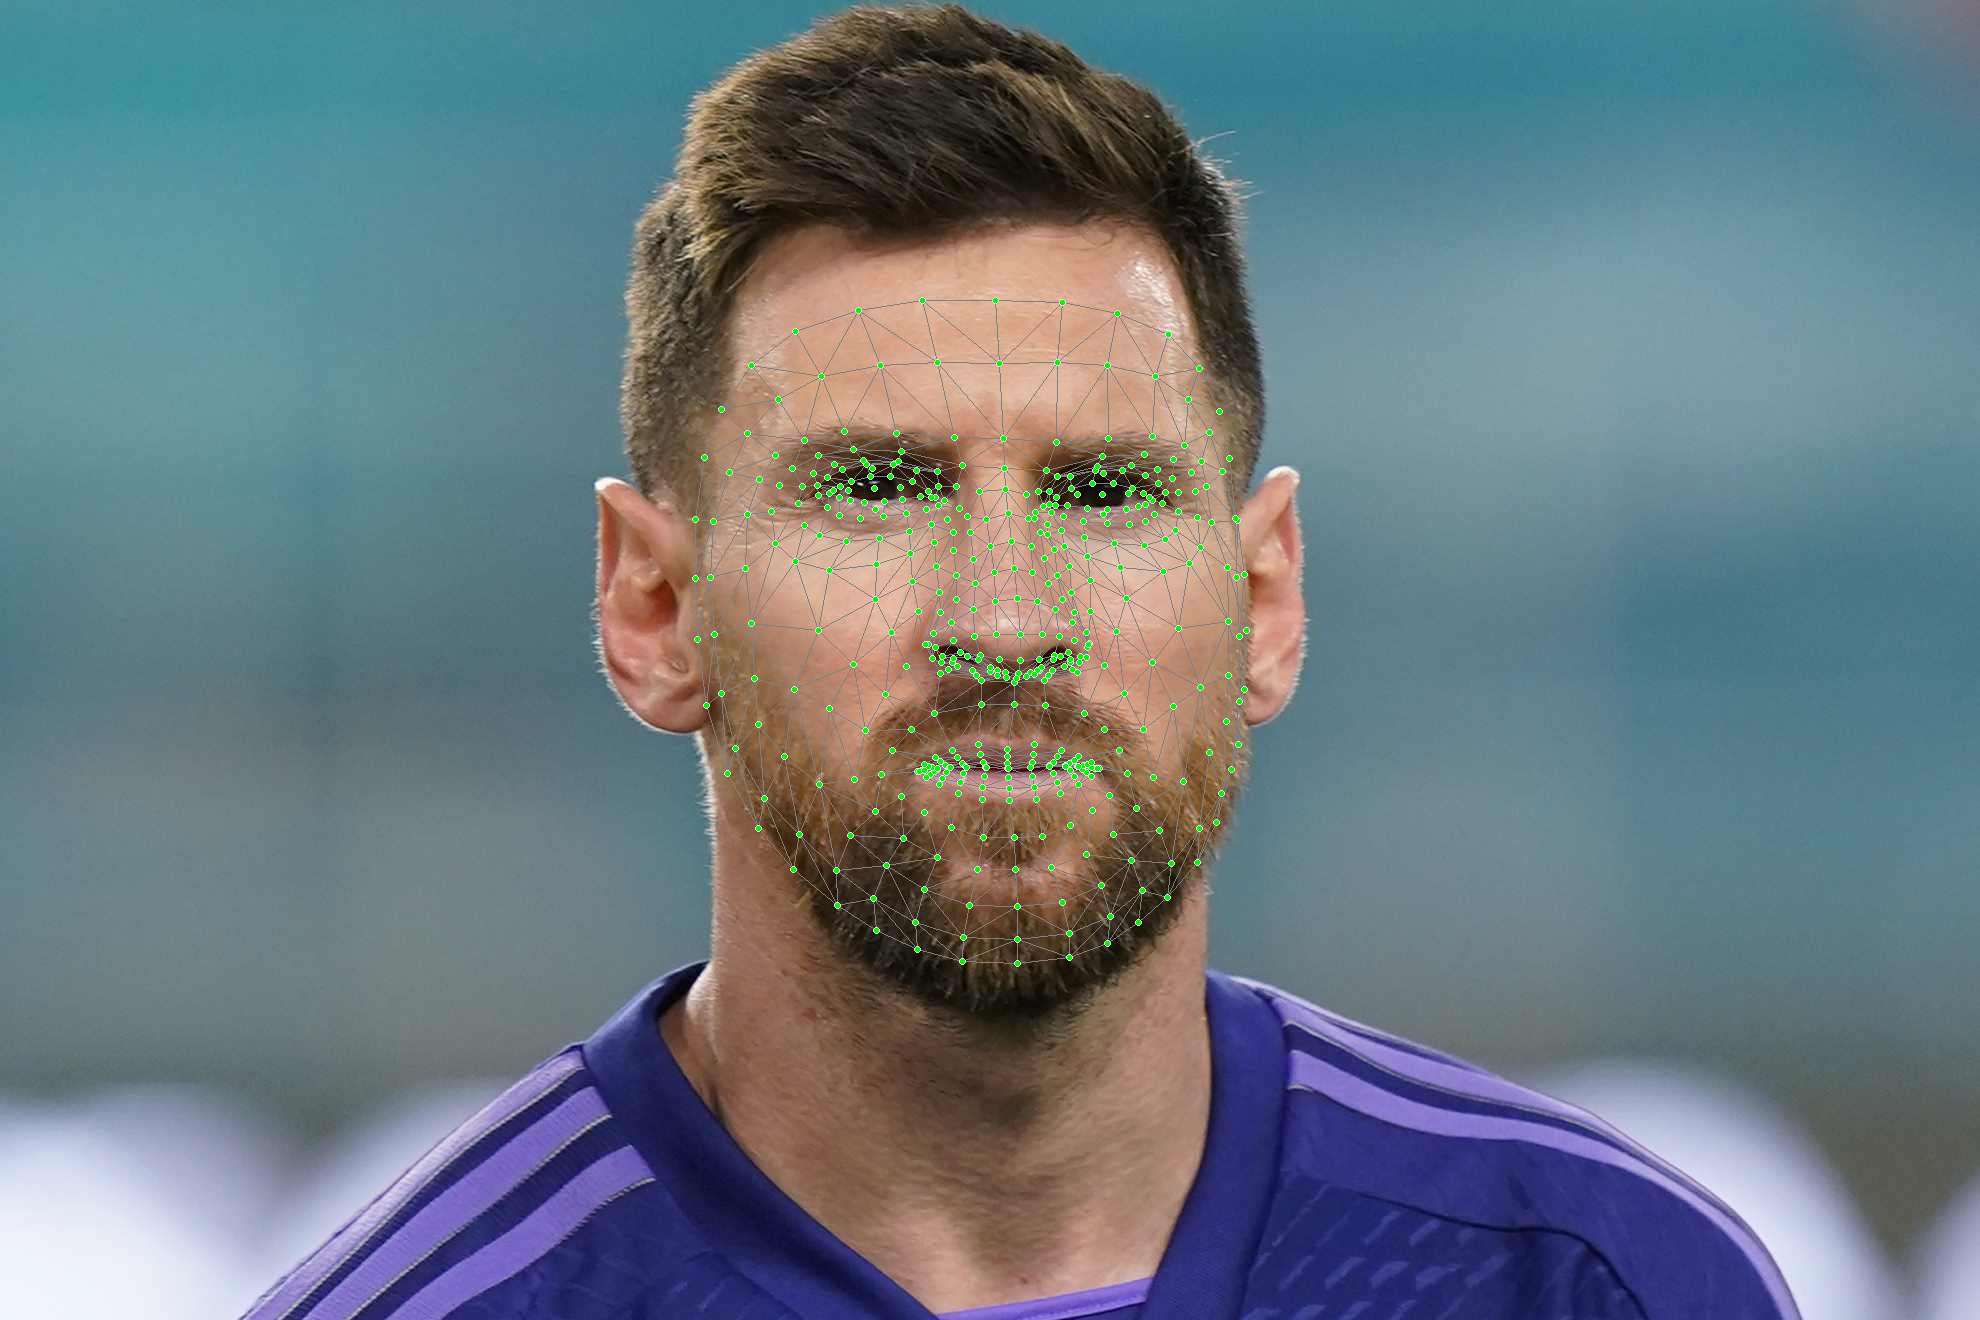

In [14]:
if face_found:
    # Create a copy of the image
    annotated_image = image.copy()
        
    mp_drawing.draw_landmarks(
        image=annotated_image,
        landmark_list=results.multi_face_landmarks[0],
        connections=mp_face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=drawing_spec,
        connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_tesselation_style())
        
    cv2.imwrite('face_tesselation_only.png', annotated_image)
    
img = Image.open('face_tesselation_only.png')
display(img)

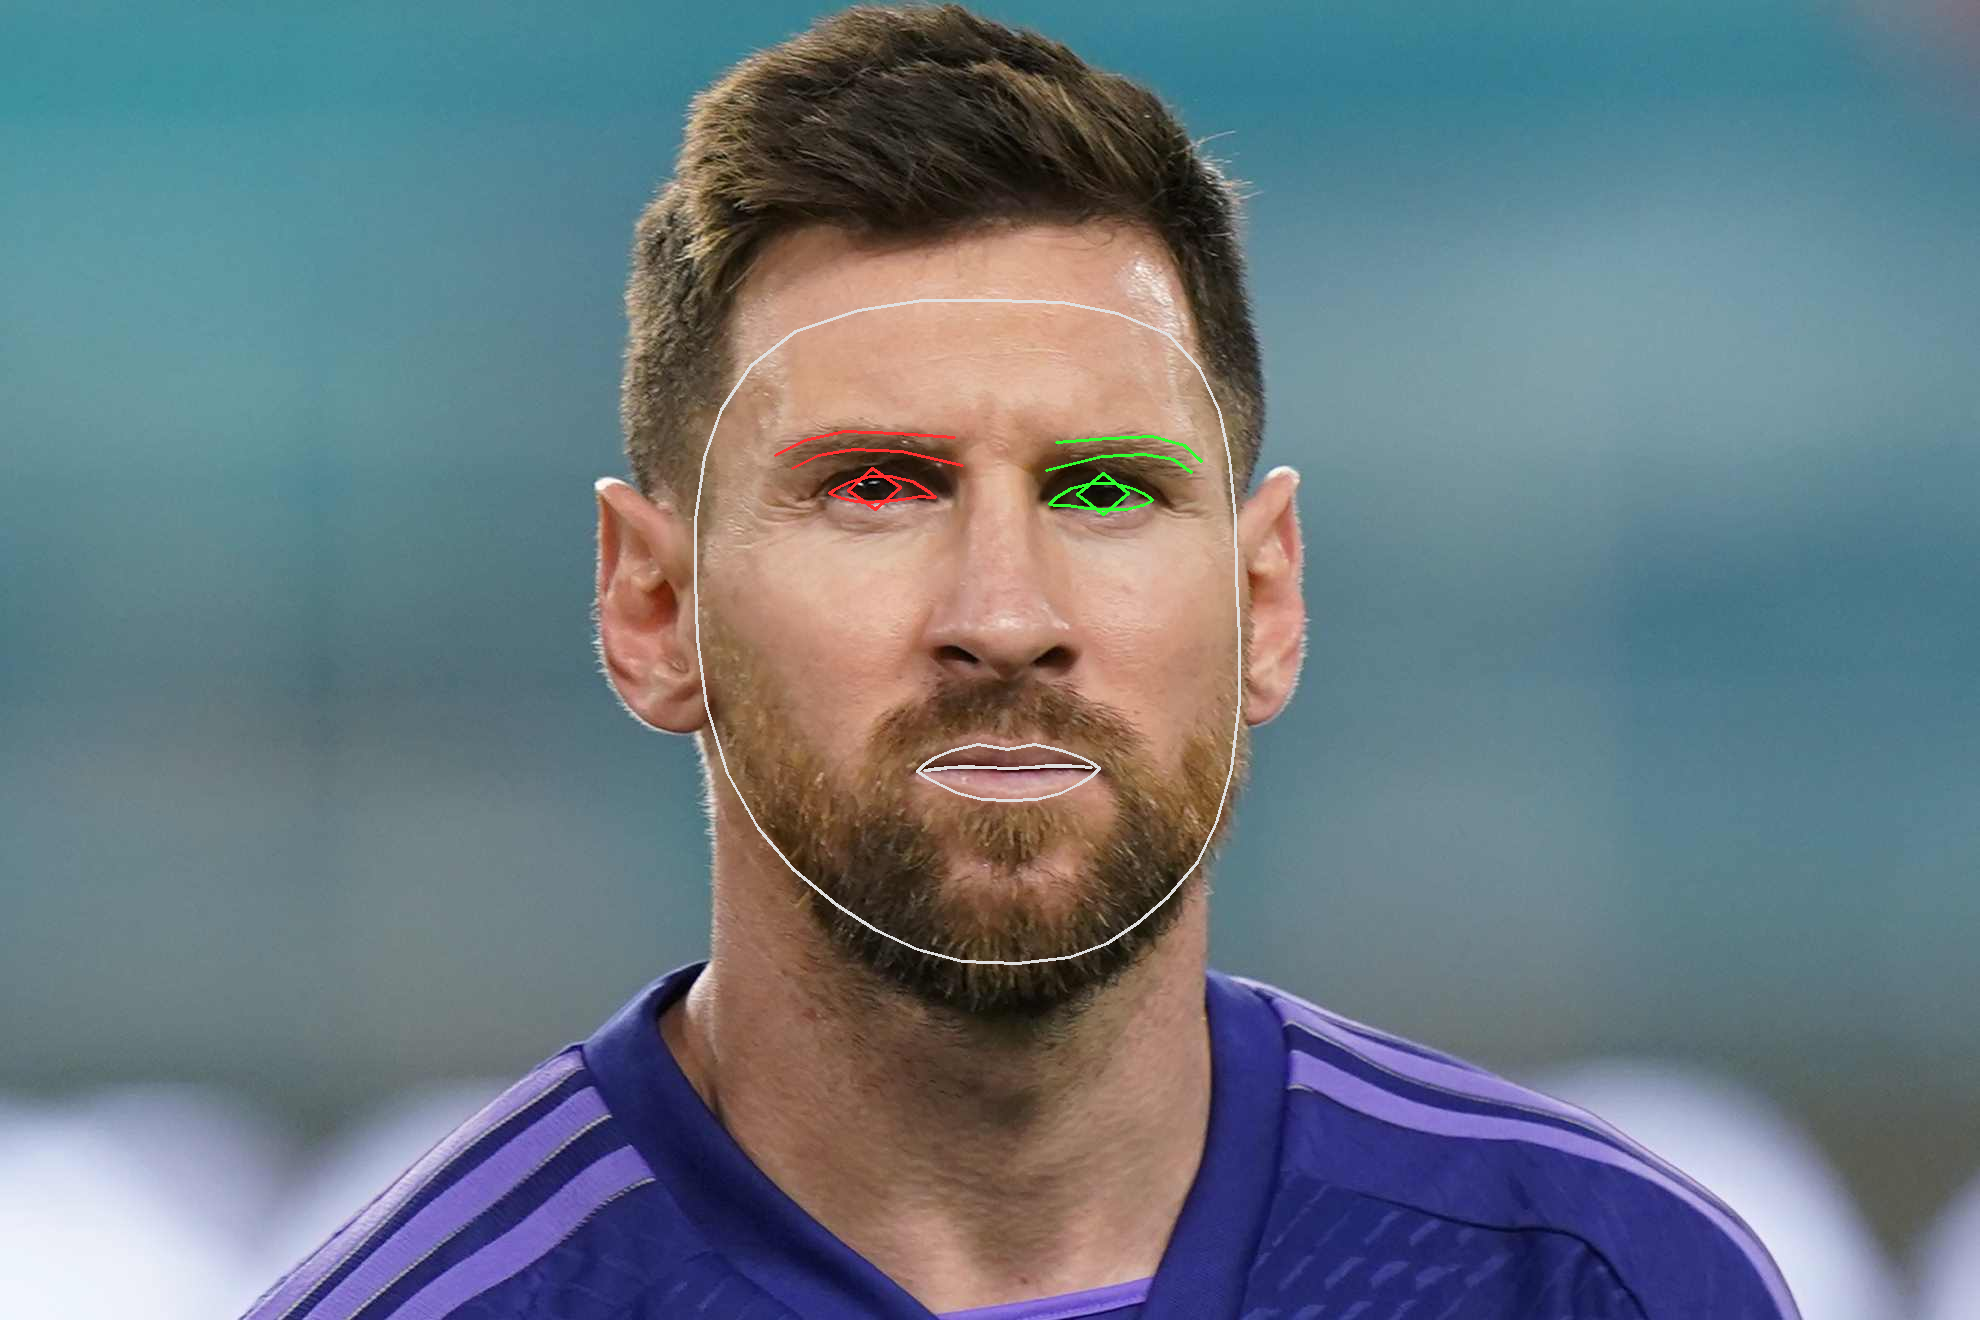

In [15]:
if face_found:
    # Create a copy of the image
    annotated_image = image.copy()
    for face_landmarks in results.multi_face_landmarks:
        
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
                .get_default_face_mesh_contours_style())
                
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_IRISES,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
                .get_default_face_mesh_iris_connections_style())

    cv2.imwrite('face_contours_and_irises.png', annotated_image)
    
img = Image.open('face_contours_and_irises.png')
display(img)

# Pose detection con mediapipe

Mediapipe facilita la detección de poses humanas. La biblioteca procesa y analiza los puntos clave del cuerpo humano en tiempo real.

In [16]:
img_url = "https://estaticos-cdn.prensaiberica.es/clip/0cfef2b5-ce7d-4c45-b27d-9ca0fabde1d2_alta-libre-aspect-ratio_default_0.jpg"
urllib.request.urlretrieve(img_url, "pose.jpg")

('pose.jpg', <http.client.HTTPMessage at 0x7f9095fea1f0>)

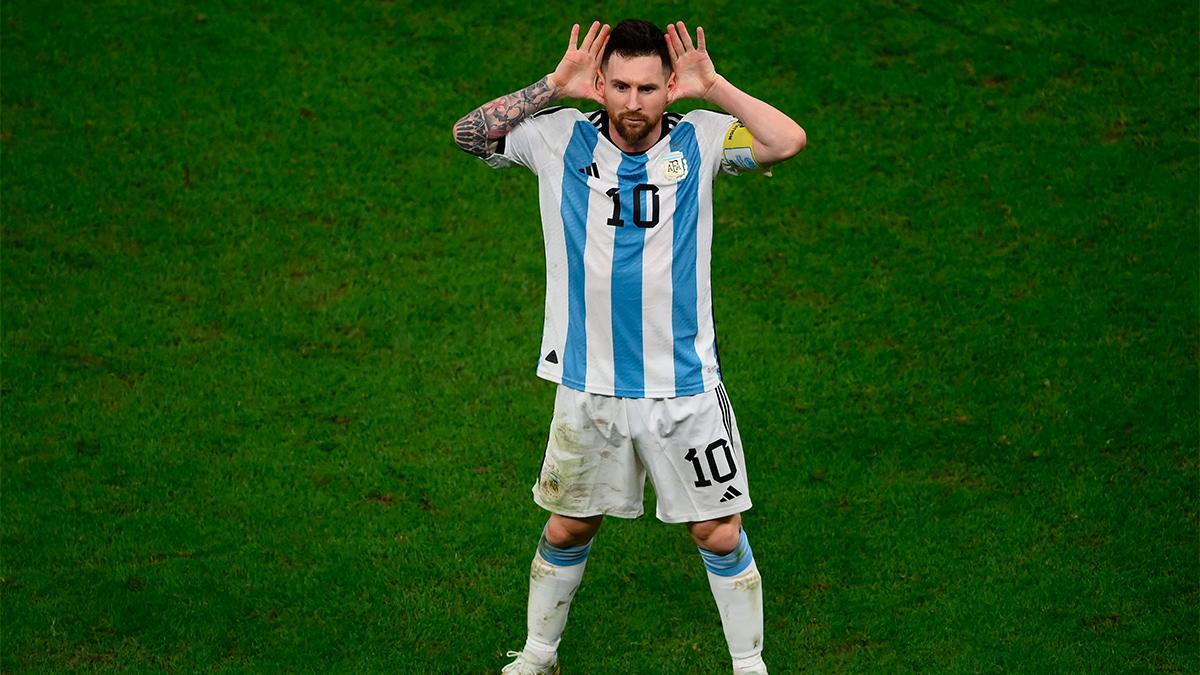

In [17]:
img = Image.open('pose.jpg')
display(img)

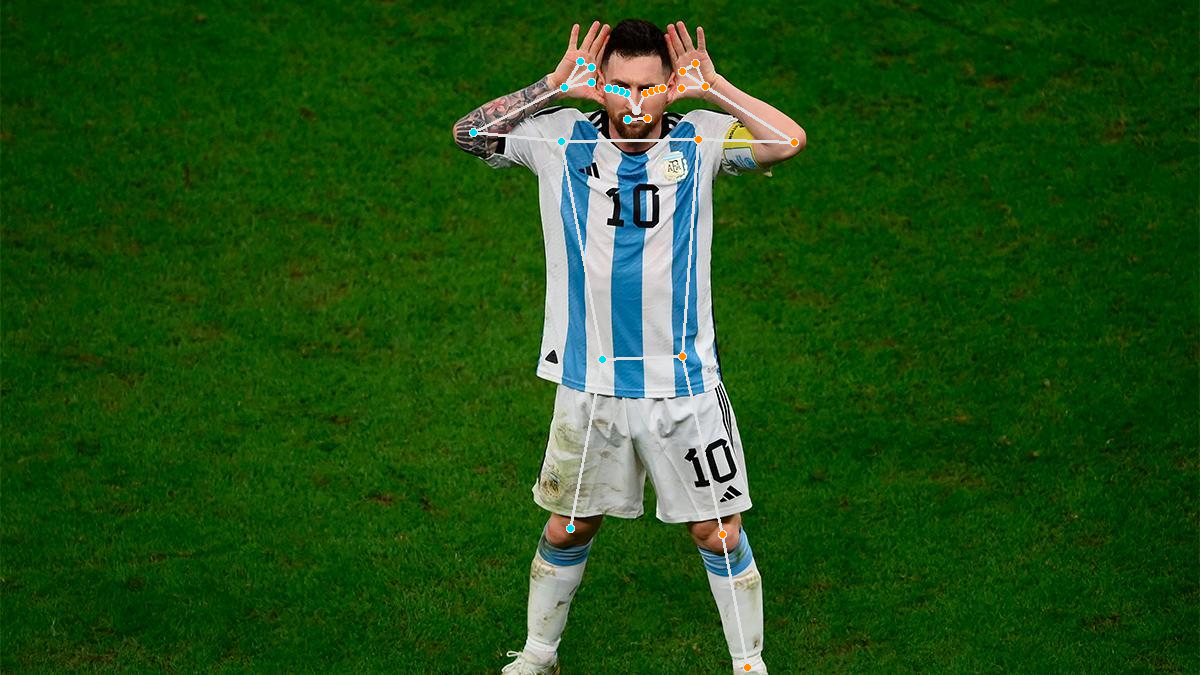

In [18]:
# Specify the image filename
file = 'pose.jpg'

# Create a MediaPipe `Pose` object
with mp_pose.Pose(static_image_mode=True,
                  model_complexity=2,
                  enable_segmentation=True) as pose:
        
    # Read the file in and get dims
    image = cv2.imread(file)

    # Convert the BGR image to RGB and then process with the `Pose` object.
    results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Copy the iamge
annotated_image = image.copy()

# Draw pose, left and right hands, and face landmarks on the image with drawing specification defaults.
mp_drawing.draw_landmarks(annotated_image, 
                          results.pose_landmarks, 
                          mp_pose.POSE_CONNECTIONS,
                          landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())

# Save image with drawing
filename = "pose_wireframe.png"
cv2.imwrite(filename, annotated_image)

# Open image
display(Image.open(filename))

## Segment Image

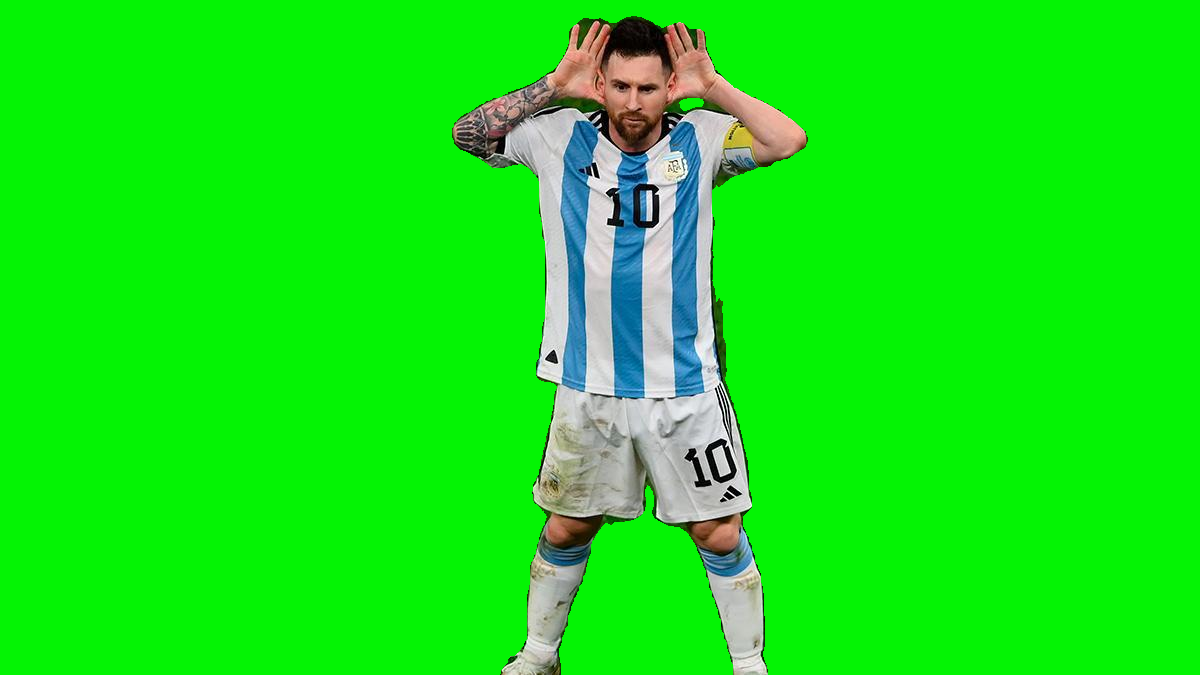

In [19]:
segmented_image = image.copy()

# Value in [0, 1] that says how "tight" to make the segmentation. Greater => tighter
tightness = .3

# Stacks the segmentation mask for 3 RGB channels, and then creates a filter for which pixels to keep
condition = np.stack((results.segmentation_mask,) * 3, axis=-1) > tightness

# Creates a black background image
bg_image = np.zeros(image.shape, dtype=np.uint8)

# Can change the color by specifying (0-255) RGB values below 
bg_image[:] = [4, 244, 4]

# Where the condition is met (i.e. above inclusion threshold), display annotated image
# Otherwise, use the background color
segmented_image = np.where(condition, segmented_image, bg_image)

filename = 'pose_green_screen.png'
cv2.imwrite(filename, segmented_image)
display(Image.open(filename))

In [24]:
# Check if pose world landmarks are available in the results
if results.pose_world_landmarks and results.pose_world_landmarks.landmark:
    landmarks = results.pose_world_landmarks.landmark
    num_landmarks = len(mp.solutions.holistic.PoseLandmark)
    
    # Prepare a data array to hold landmark coordinates
    data = np.empty((3, num_landmarks))
    
    # Extract x, y, z coordinates of each landmark into the data array
    for i, landmark in enumerate(landmarks):
        data[:, i] = (landmark.x, landmark.y, landmark.z)
else:
    print("No pose world landmarks available.")       